## Import Libraries and Load the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
 !unzip '/content/drive/MyDrive/Colab Notebooks/Dataset/Mapcrop.zip'

Archive:  /content/drive/MyDrive/Colab Notebooks/Dataset/Mapcrop.zip
   creating: Data/
   creating: Data/HR/
  inflating: Data/HR/0.png           
  inflating: Data/HR/1.png           
  inflating: Data/HR/10.png          
  inflating: Data/HR/11.png          
  inflating: Data/HR/12.png          
  inflating: Data/HR/13.png          
  inflating: Data/HR/14.png          
  inflating: Data/HR/15.png          
  inflating: Data/HR/16.png          
  inflating: Data/HR/17.png          
  inflating: Data/HR/18.png          
  inflating: Data/HR/19.png          
  inflating: Data/HR/2.png           
  inflating: Data/HR/20.png          
  inflating: Data/HR/21.png          
  inflating: Data/HR/22.png          
  inflating: Data/HR/23.png          
  inflating: Data/HR/24.png          
  inflating: Data/HR/25.png          
  inflating: Data/HR/26.png          
  inflating: Data/HR/27.png          
  inflating: Data/HR/28.png          
  inflating: Data/HR/29.png          
  inflating: Dat

## Exploring the Dataset

In [4]:
import pathlib
import os
data_dir = '/content/Data'
data_dir = pathlib.Path(data_dir)

In [5]:
print(os.listdir('/content/Data'))

['LR', 'HR']


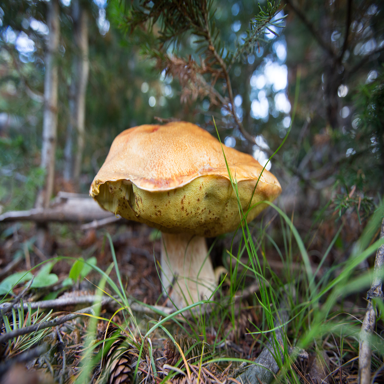

In [6]:
import PIL
high_res = list(data_dir.glob('HR/*'))
PIL.Image.open(str(high_res[0]))

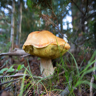

In [7]:
low_res = list(data_dir.glob('LR/*'))
PIL.Image.open(str(low_res[0]))

## Data Pre-processing

In [8]:
import cv2
from tensorflow.keras.utils import img_to_array
high_img = []
path = '/content/Data/HR'
files = os.listdir(path)
#files = sorted_alphanumeric(files)
for i in files:    
  img = cv2.imread(path + '/'+i,1)
  # open cv reads images in BGR format so we have to convert it to RGB
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  #resizing image
  img = cv2.resize(img, (256, 256))
  img = img.astype('float32') / 255.0
  high_img.append(img_to_array(img))

In [9]:
low_img = []
path = '/content/Data/LR'
files = os.listdir(path)
#files = sorted_alphanumeric(files)
for i in files: 
  img = cv2.imread(path + '/'+i,1)
  #resizing image
  img = cv2.resize(img, (256, 256))
  img = img.astype('float32') / 255.0
  low_img.append(img_to_array(img))

In [10]:
print(len(high_img))
print(len(low_img))

100
100


In [11]:
## Splitting the data into training and validation (80:20%)
train_high_image = high_img[:80]
train_low_image = low_img[:80]

validation_high_image = high_img[80:]
validation_low_image = low_img[80:]

In [12]:
## Reshaping the images
train_high_image = np.reshape(train_high_image,(len(train_high_image),256,256,3))
train_low_image = np.reshape(train_low_image,(len(train_low_image),256,256,3))

validation_high_image= np.reshape(validation_high_image,(len(validation_high_image),256,256,3))
validation_low_image = np.reshape(validation_low_image,(len(validation_low_image),256,256,3))

## Model Building

In [13]:
from keras import layers
import tensorflow as tf
import keras
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

def model():
    inputs = layers.Input(shape= [256,256,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(256,(3,3),True)(d2)
    d5 = down(512,(3,3),True)(d3)
    d6 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d6)
    u1 = layers.concatenate([u1,d5])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d4])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d3])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d2])
    u5 = up(128,(3,3),False)(u4)
    u5 = layers.concatenate([u5,d1])
    u6 = up(3,(3,3),False)(u5)
    u6 = layers.concatenate([u6,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u6)
    return tf.keras.Model(inputs=inputs, outputs=output)

model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128, 128, 12  3584        ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 64, 64, 128)  147584      ['sequential[0][0]']             
                                                                                              

In [14]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',metrics = ['acc'])

In [15]:
history = model.fit(train_low_image, train_high_image, epochs = 20, batch_size = 1, validation_data = (validation_low_image,validation_high_image))

Epoch 1/20
80/80 [==============================] - 69s 846ms/step - loss: 0.2042 - acc: 0.3730 - val_loss: 0.1109 - val_acc: 0.4079
Epoch 2/20
80/80 [==============================] - 67s 834ms/step - loss: 0.0906 - acc: 0.5280 - val_loss: 0.0774 - val_acc: 0.5208
Epoch 3/20
80/80 [==============================] - 67s 836ms/step - loss: 0.0810 - acc: 0.5494 - val_loss: 0.0800 - val_acc: 0.6411
Epoch 4/20
80/80 [==============================] - 65s 812ms/step - loss: 0.0714 - acc: 0.6164 - val_loss: 0.0715 - val_acc: 0.6162
Epoch 5/20
80/80 [==============================] - 66s 821ms/step - loss: 0.0607 - acc: 0.6782 - val_loss: 0.0570 - val_acc: 0.7339
Epoch 6/20
80/80 [==============================] - 66s 822ms/step - loss: 0.0533 - acc: 0.7424 - val_loss: 0.0569 - val_acc: 0.6832
Epoch 7/20
80/80 [==============================] - 63s 784ms/step - loss: 0.0534 - acc: 0.7258 - val_loss: 0.0582 - val_acc: 0.7198
Epoch 8/20
80/80 [==============================] - 60s 756ms/step - 

## Predictions

In [16]:
def plot_images(high,low,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High Image', color = 'green', fontsize = 20)
    plt.imshow(high)
    plt.subplot(1,3,2)
    plt.title('Low Image ', color = 'black', fontsize = 20)
    plt.imshow(low)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

for i in range(1,10):
  validation_low_image= np.reshape(validation_low_image,(len(validation_low_image),256,256,3))
  predicted = np.clip(model.predict(validation_low_image[i].reshape(1,256, 256,3)),0.0,1.0).reshape(256, 256,3)
  plot_images(validation_high_image[i],validation_low_image[i],predicted)

Output hidden; open in https://colab.research.google.com to view.

## Evaluation

In [23]:
def model_plot(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

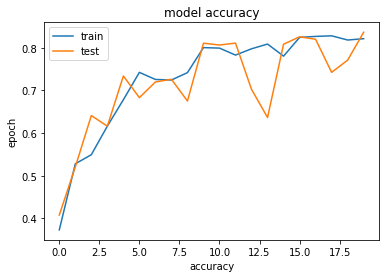

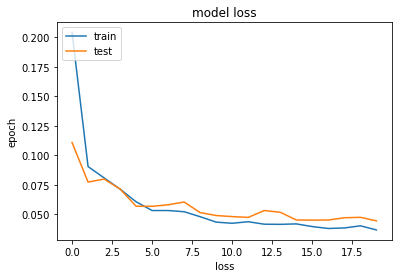

In [21]:
model_plot(history)

In [19]:
from keras import backend as K
def PSNR(y_true, y_pred):
    max_pixel = 1.0
    return (10.0 * K.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true), axis=-1)))) / 2.303

def SSIM(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))